### CMB Assigment 2 Program ###

In [1]:
# Program, run imports
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import seaborn as sns
import requests
sns.set(style="darkgrid")

Create Pandas Dataframe

In [2]:
#df = pd.read_csv("data/21-12-23_complete.csv")
# data_folder = "/Users/Fabian/Desktop/"
data_folder = "/Users/Fabian/Desktop/"
df = pd.read_csv(data_folder + "1dayAll.csv", encoding = "latin")
print(df)
# ['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info', 'dst port']


             No.                        Time           Source  \
0              1  2022-01-16 22:04:03.993585     192.168.0.88   
1              2  2022-01-16 22:04:03.997303      192.168.0.5   
2              3  2022-01-16 22:04:04.055476  199.232.138.248   
3              4  2022-01-16 22:04:04.057104      192.168.0.9   
4              5  2022-01-16 22:04:04.070783  199.232.138.248   
...          ...                         ...              ...   
1117455  1117456  2022-01-17 17:05:50.550259   188.164.238.26   
1117456  1117457  2022-01-17 17:05:50.550547   188.164.238.26   
1117457  1117458  2022-01-17 17:05:50.595386     192.168.0.22   
1117458  1117459  2022-01-17 17:05:50.605007     192.168.0.22   
1117459  1117460  2022-01-17 17:05:50.607387   188.164.238.26   

             Destination Protocol  Length  \
0            192.168.0.5      SSH     190   
1           192.168.0.88      TCP      66   
2            192.168.0.9      TCP     730   
3        199.232.138.248      TCP      

Filter local traffic

In [16]:
# source and destination should not start with 192.168 to filter local network
filtered = df.loc[~df['Source'].str.startswith("192.168", na=False) & df['Destination'].str.startswith("192.168", na=False) |
                 df['Source'].str.startswith("192.168", na=False) & ~df['Destination'].str.startswith("192.168", na=False)]
# filter multicast
filtered = filtered.loc[~filtered['Protocol'].str.contains("MDNS")]

df = filtered.copy()
#print(df)

print(df.loc[~df['Protocol'].str.contains("MQTT")])

             No.                        Time           Source  \
2              3  2022-01-16 22:04:04.055476  199.232.138.248   
3              4  2022-01-16 22:04:04.057104      192.168.0.9   
4              5  2022-01-16 22:04:04.070783  199.232.138.248   
5              6  2022-01-16 22:04:04.109911      192.168.0.9   
6              7  2022-01-16 22:04:04.363595  199.232.138.248   
...          ...                         ...              ...   
1117455  1117456  2022-01-17 17:05:50.550259   188.164.238.26   
1117456  1117457  2022-01-17 17:05:50.550547   188.164.238.26   
1117457  1117458  2022-01-17 17:05:50.595386     192.168.0.22   
1117458  1117459  2022-01-17 17:05:50.605007     192.168.0.22   
1117459  1117460  2022-01-17 17:05:50.607387   188.164.238.26   

             Destination Protocol  Length  \
2            192.168.0.9      TCP     730   
3        199.232.138.248      TCP      66   
4            192.168.0.9      TCP    1842   
5        199.232.138.248      TCP      

In [4]:
# helper functions
def utcEntryToTimestamp(entry):
    if '.' in entry:
        row_entry = entry.split(".")[0]
    else:
        row_entry = entry.split(",")[0]
    TIME_FORMAT='%Y-%m-%d %H:%M:%S'
    ts = int(datetime.strptime(row_entry, TIME_FORMAT).timestamp())
    return ts

def utcRowToTimestamp(row):
    return utcEntryToTimestamp(row.at['Time'])
utcRowToTimestamp(df.iloc[0])
# print(df.loc[0].at['Time'])

1642367043

### Protocol packet distribution ###

Protocol
0x0006            1
ARP           11242
BROWSER         211
DHCP           1733
DHCPv6           41
DNS            2609
ECATF             1
ENIP             24
H1                1
HTTP           6097
HTTP/JSON       839
HTTP/XML      12901
ICMP            797
ICMPv6        12681
IGMPv2         6638
IGMPv3         5697
KINK              1
LLC               1
LLDP           4433
MQTT           5026
NBNS            153
NTP             556
QUIC           1835
SSDP          62486
SSH              67
SSHv2           256
SSLv2          7018
TC-NV             1
TCP          691996
TDLS              4
TLSv1           200
TLSv1.2      112881
TLSv1.3         851
UDP           34972
WLCCP             2
XID              10
ieee1905       4525
Name: Source, dtype: int64


/var/folders/px/zjht8g6j4bvglsnf70rp41d80000gn/T/ipykernel_17469/1857181538.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


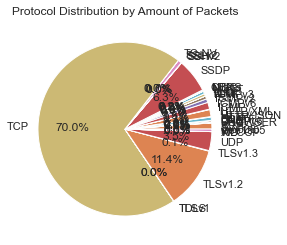

In [5]:
print(df.groupby('Protocol').Source.count())

count_protocol_packets = df.groupby('Protocol').Source.count()

fig, ax = plt.subplots()
plt.title('Protocol Distribution by Amount of Packets')
ax.pie(count_protocol_packets, labels=count_protocol_packets.keys(), autopct='%1.1f%%',)
fig.show()

### Amount of data traffic per protocol ###

Protocol
0x0006             242
ARP             584044
BROWSER          53050
DHCP            624222
DHCPv6            6583
DNS             278547
ECATF             1514
ENIP             17138
H1                  77
HTTP           1506018
HTTP/JSON       410639
HTTP/XML       7247633
ICMP             80785
ICMPv6         1609862
IGMPv2          390986
IGMPv3          349786
KINK               666
LLC                 74
LLDP            265980
MQTT            448125
NBNS             15948
NTP              50040
QUIC            978225
SSDP          22418224
SSH              10038
SSHv2            41368
SSLv2         12790803
TC-NV              622
TCP          466155471
TDLS               252
TLSv1           148764
TLSv1.2       79360695
TLSv1.3         588664
UDP           24665610
WLCCP              148
XID                600
ieee1905        271500
Name: Length, dtype: int64


/var/folders/px/zjht8g6j4bvglsnf70rp41d80000gn/T/ipykernel_17469/3895533642.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


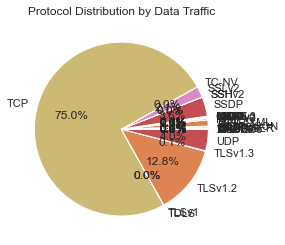

In [6]:
count_protocol_traffic = df.groupby('Protocol').Length.sum()
print(count_protocol_traffic)
fig, ax = plt.subplots()
plt.title('Protocol Distribution by Data Traffic')
ax.pie(count_protocol_traffic, labels=count_protocol_traffic.keys(), autopct='%1.1f%%',)
fig.show()

### Average Data length per Protocol Type ###

Protocol
0x0006        242.000000
ARP            51.951966
BROWSER       251.421801
DHCP          360.197346
DHCPv6        160.560976
DNS           106.763894
ECATF        1514.000000
ENIP          714.083333
H1             77.000000
HTTP          247.009677
HTTP/JSON     489.438617
HTTP/XML      561.788466
ICMP          101.361355
ICMPv6        126.950714
IGMPv2         58.901175
IGMPv3         61.398280
KINK          666.000000
LLC            74.000000
LLDP           60.000000
MQTT           89.161361
NBNS          104.235294
NTP            90.000000
QUIC          533.092643
SSDP          358.771949
SSH           149.820896
SSHv2         161.593750
SSLv2        1822.570960
TC-NV         622.000000
TCP           673.638968
TDLS           63.000000
TLSv1         743.820000
TLSv1.2       703.047413
TLSv1.3       691.732080
UDP           705.295951
WLCCP          74.000000
XID            60.000000
ieee1905       60.000000
Name: Length, dtype: float64


/var/folders/px/zjht8g6j4bvglsnf70rp41d80000gn/T/ipykernel_17469/212732153.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


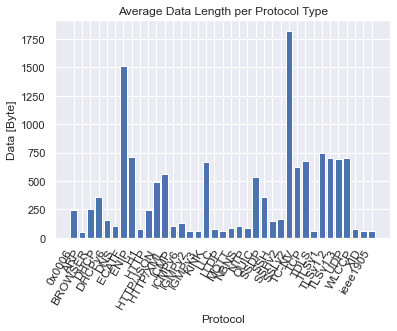

In [7]:
average_protocol_packet_length = df.groupby('Protocol').Length.sum() / df.groupby('Protocol').Length.count()
print(average_protocol_packet_length)
fig, ax = plt.subplots()
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='x', which='minor', labelsize=12)
plt.xlabel('Protocol')
plt.ylabel('Data [Byte]')
plt.title('Average Data Length per Protocol Type')
ax.bar(average_protocol_packet_length.keys(), average_protocol_packet_length, align='center',)
plt.xticks(rotation=60, ha="right")
fig.show()

### Source addresses ###

In [8]:
print(df.groupby('Source').Time.count())
print(df.groupby('Destination').Time.count().sort_values())

unique_dests = df['Destination'].unique()

# write ip address destinations to file
file1 = open("Testfile.txt","w")
for row in unique_dests:
    file1.write(row + "\n")
file1.close()

Source
0.0.0.0                        22
104.121.176.87                 25
104.122.85.142                 18
104.18.30.112                   8
104.18.30.82                  101
                             ... 
fe80::6d:211b:23be:3c18       262
fe80::a458:46f9:bf54:6262     896
fe80::bbd8:80cf:6a7a:1ee8     104
fe80::de53:7cff:fedd:5e2e    5274
fe80::dea6:32ff:fea9:b652     544
Name: Time, Length: 348, dtype: int64
Destination
ff02::1:fffb:16f2         1
5.9.7.51                  1
5.9.57.158                1
216.239.35.8              1
94.16.116.137             1
                      ...  
199.232.138.248       88263
192.168.0.200        115103
192.168.0.22         149743
188.164.238.26       154839
192.168.0.9          282863
Name: Time, Length: 377, dtype: int64


In [9]:
print(df.groupby('Source').Time.count())
print(df.groupby('Destination').Time.count().sort_values())

Source
0.0.0.0                        22
104.121.176.87                 25
104.122.85.142                 18
104.18.30.112                   8
104.18.30.82                  101
                             ... 
fe80::6d:211b:23be:3c18       262
fe80::a458:46f9:bf54:6262     896
fe80::bbd8:80cf:6a7a:1ee8     104
fe80::de53:7cff:fedd:5e2e    5274
fe80::dea6:32ff:fea9:b652     544
Name: Time, Length: 348, dtype: int64
Destination
ff02::1:fffb:16f2         1
5.9.7.51                  1
5.9.57.158                1
216.239.35.8              1
94.16.116.137             1
                      ...  
199.232.138.248       88263
192.168.0.200        115103
192.168.0.22         149743
188.164.238.26       154839
192.168.0.9          282863
Name: Time, Length: 377, dtype: int64


### DNS requests ###

In [10]:
df_dns = df[df['Protocol'].isin(['DNS'])]
df_dns.head()
df_dns_requests_1 = df_dns[df_dns['Info'].str.contains('Standard query')]
# does not contain response
df_dns_requests_2 = df_dns_requests_1[~df_dns_requests_1['Info'].str.contains('response')]
df_dns_resources = df_dns_requests_2['Info'].apply(lambda x: x.split(' ')[-1]).value_counts()
print(df_dns_resources)
# print(df_dns_requests)
# print(df_dns['Info'])


server.chillibits.com              437
firetvcaptiveportal.com             79
pool.ntp.org                        43
0.debian.pool.ntp.org               42
graph.facebook.com                  35
                                  ... 
mobilemaps-pa-gz.googleapis.com      1
firmware.sensor.community            1
mobilemaps.googleapis.com            1
238.36.251.142.in-addr.arpa          1
lh4.googleusercontent.com            1
Name: Info, Length: 134, dtype: int64


### IP Wordlwide location

In [11]:
df_destinations =  df['Destination'].unique()

for dest in df_destinations[:10]: # 10 entries limit for now
    if dest.startswith("192.168"):
            continue
    headers = { 'User-Agent': "keycdn-tools:https://www.example.com" }
    url = "https://tools.keycdn.com/geo.json?host={}".format(dest)
    r = requests.get(url, headers=headers)
    print(r.json() )  


{'status': 'success', 'description': 'Data successfully received.', 'data': {'geo': {'host': '199.232.138.248', 'ip': '199.232.138.248', 'rdns': '199.232.138.248', 'asn': 54113, 'isp': 'FASTLY', 'country_name': 'Germany', 'country_code': 'DE', 'region_name': 'Hesse', 'region_code': 'HE', 'city': 'Frankfurt am Main', 'postal_code': '60313', 'continent_name': 'Europe', 'continent_code': 'EU', 'latitude': 50.1188, 'longitude': 8.6843, 'metro_code': None, 'timezone': 'Europe/Berlin', 'datetime': '2022-01-17 18:16:22'}}}
{'status': 'success', 'description': 'Data successfully received.', 'data': {'geo': {'host': '188.164.238.26', 'ip': '188.164.238.26', 'rdns': '188.164.238.26', 'asn': 198145, 'isp': 'SWM Services GmbH', 'country_name': 'Germany', 'country_code': 'DE', 'region_name': 'Bavaria', 'region_code': 'BY', 'city': 'Munich', 'postal_code': '80331', 'continent_name': 'Europe', 'continent_code': 'EU', 'latitude': 48.1336, 'longitude': 11.5658, 'metro_code': None, 'timezone': 'Europe/B

### Data traffic over time ###

from  1642367043  to  1642435550
77
[30504. 39551. 41635.  8860.  8608.  8503.  8592.  8541.  8457.  8778.
  8507.  8439.  8442.  8566.  8462.  8580.  8572. 11555.  8471.  8468.
  8704.  8407.  8508.  8545.  8424.  8536.  8491.  8498.  8362.  8462.
  8575.  8651.  8640.  8849.  8469.  8467.  8567.  8493.  8505.  8530.
  8706. 10706.  8738.  8833.  8678.  9140.  8923.  9162.  9796.  8714.
  8698.  8950.  8718.  8815.  8829.  8680.  8476.  9094.  8743. 11931.
  8781.  8711.  8741.  9006. 47024. 47449. 46395. 47705. 45919. 44725.
 11410.  9131.  9505.  8941.  9628.  8882.  3730.]
[28966. 37658. 40359.  3591.  3586.  3515.  3551.  3524.  3492.  3640.
  3561.  3545.  3541.  3579.  3553.  3590.  3552.  6173.  3559.  3573.
  3661.  3562.  3594.  3563.  3564.  3625.  3582.  3538.  3573.  3608.
  3611.  3659.  3633.  3743.  3575.  3621.  3638.  3592.  3605.  3605.
  3664.  4801.  3616.  3638.  3584.  3789.  3678.  3770.  4101.  3633.
  3603.  3683.  3624.  3688.  3664.  3607.  3568.  4047.  362

/var/folders/px/zjht8g6j4bvglsnf70rp41d80000gn/T/ipykernel_17469/2888101978.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/px/zjht8g6j4bvglsnf70rp41d80000gn/T/ipykernel_17469/2888101978.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


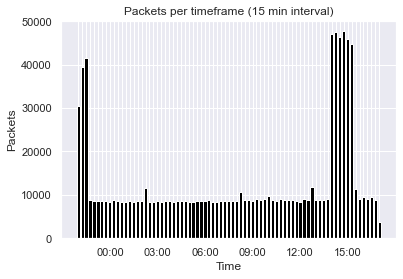

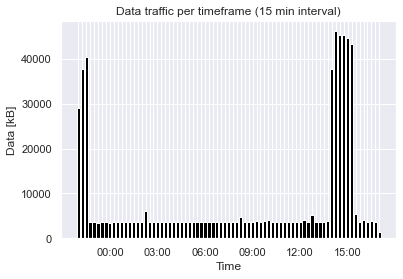

In [12]:
def timeMapping(x):
    # include time difference UTC+1
    time = datetime.utcfromtimestamp(x*min_15_duration + 3600)
    if time.minute == 0 and time.hour % 3 == 0:
        return time.strftime("%H:%M")
    else:
        return ""

# find first and last timestamp, then create data structure
min_15_duration = 60 * 15
df_time_mod = df.copy()
df_time_mod['Time'] = df_time_mod['Time'].apply(lambda x: utcEntryToTimestamp(x)) # map to 15 min window
df_time_mod.head()
first_entry = df_time_mod.iloc[0].at['Time'] // min_15_duration
last_entry = df_time_mod.iloc[-1].at['Time'] // min_15_duration

print('from ', df_time_mod.iloc[0].at['Time'], " to ", df_time_mod.iloc[-1].at['Time'])

count_packets = np.zeros(last_entry - first_entry + 1)
length_packets = np.zeros(last_entry - first_entry + 1)

x_values_packets = list(range(first_entry, last_entry + 1))
print(len(x_values_packets))

mapping_res = list(map(timeMapping, x_values_packets))

# print(mapping_res)

for index, row in df_time_mod.iterrows():
    ts = row.at['Time'] // min_15_duration
    count_packets[ts - first_entry] += 1
    length_packets[ts - first_entry] += row.at['Length']

length_packets = length_packets // 1000
print(count_packets)
print(length_packets)

fig, ax = plt.subplots()
plt.xlabel('Time')
plt.ylabel('Packets')
plt.title('Packets per timeframe (15 min interval)')
plt.xticks(x_values_packets, mapping_res)
ax.bar(x_values_packets, count_packets, color='black')
fig.show()

fig, ax = plt.subplots()
plt.xlabel('Time')
plt.ylabel('Data [kB]')
plt.title('Data traffic per timeframe (15 min interval)')
plt.xticks(x_values_packets, mapping_res)
ax.bar(x_values_packets, length_packets, color='black')
fig.show()